<a href="https://colab.research.google.com/github/calcudimen/Distillation/blob/main/Distillation_dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def generate_gaussian_variables(n, mean=0, std_dev=1):
    """
    Generate Dn Gaussian random variables.

    Parameters:
    - n: Number of random variables to generate.
    - mean: Mean of the Gaussian distribution (default is 0).
    - std_dev: Standard deviation of the Gaussian distribution (default is 1).

    Returns:
    A NumPy array containing Dn Gaussian random variables.
    """
    return np.random.normal(mean, std_dev, n)

def generate_data(N, Dn, true_feature):
    """
    Generate synthetic data for logistic regression.

    Args:
    - N (int): Number of data points.
    - Dn (int): Dimension of the feature vector.
    - true_feature (numpy array): True feature vector.

    Returns:
    - X (numpy array): Design matrix of shape (N, Dn) with synthetic features.
    - y (numpy array): Binary labels (0 or 1) generated using logistic function.
    """

    # Generate random feature matrix X
    X = np.random.binomial(1,0.5, (N,Dn))

    # Generate binary labels using the logistic function
    inner_product = np.dot(X, true_feature)
    prob = 1 / (1 + np.exp(-inner_product))
    y = np.random.binomial(1, prob, size=N)

    return X, y

# Example usage:
# N = 100
# Dn = 10
# true_feature = generate_gaussian_variables(Dn)
# X, y = generate_data(N, Dn, true_feature)


# Example: Generate 10 data points with Dn=5 and true_feature vector
N = 10**6
Dn = 100
true_feature = generate_gaussian_variables(Dn)  # Assuming true_feature is generated using Gaussian distribution

X, y = generate_data(N, Dn, true_feature)
print(N)

# print(f"Generated {N} data points:")
# for i in range(N):
#     print(f"Data Point {i+1}: X={X[i]}, y={y[i]}")
print(f"true feature vector: {true_feature}")

1000000
true feature vector: [ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
  2.26975462 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877
  0.15494743  0.37816252 -0.88778575 -1.98079647 -0.34791215  0.15634897
  1.23029068  1.20237985 -0.38732682 -0.30230275 -1.04855297 -1.42001794
 -1.70627019  1.9507754  -0.50965218 -0.4380743  -1.25279536  0.77749036
 -1.61389785 -0.21274028 -0.89546656  0.3869025  -0.51080514 -1.18063218
 -0.02818223  0.42833187  0.06651722  0.3024719  -0.63432209 -0.36274117
 -0.67246045 -0.35955316 -0.81314628 -1.7262826   0.17742614 -0.40178094
 -1.63019835  0.46278226 -0.90729836  0.0519454   0.72909056  0.12898291
  1.13940068 -1.23482582  0.40234164 -0.68481009 -0.87079715 -0.57884966
 -0.31155253  0.056165

In [ ]:
# Choose a random subset of coordinates for the teacher's feature set
Dt = 10
teacher_feature_set = np.random.choice(Dn, Dt, replace=False)

# Choose a random subset of coordinates for the student's feature set (subset of teacher's feature set)
Ds = 10
student_feature_set = np.random.choice(teacher_feature_set, Ds, replace=False)

In [ ]:
def logit_loss(y_true, y_pred):
    # Compute the logit loss
    loss = -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)
    return np.mean(loss)

In [ ]:
def adagrad_optimizer_teacher_logit_with_regret(X, y, teacher_feature_set, learning_rate=0.2, epochs=1, epsilon=1e-8, learning_rate_decay=0.5, has_baseline = False, features_baseline = [], const_baseline = 0):
    N, Dn = X.shape
    true_feature_teacher = np.zeros(Dn)
    true_feature_teacher[teacher_feature_set] = np.random.normal(size = len(teacher_feature_set))
    hidden_feature_value_teacher = np.random.normal()  # Initialize hidden_feature_value_teacher randomly

    G_true_feature_teacher = np.zeros(Dn)  # Initialize squared gradient accumulator for true_feature_teacher
    G_hidden_feature_teacher = 0  # Initialize squared gradient accumulator for hidden_feature_value_teacher

    logit_losses_teacher = []
    regrets = []
    prev_logit_loss_teacher = float('inf')
    regret = 0

    for epoch in range(epochs):
        logit_loss_teacher = 0  # Initialize logit loss for the current epoch for teacher

        for i in range(N):
            # Predict the label using the logistic function of the inner product
            inner_product = np.dot(X[i, teacher_feature_set], true_feature_teacher[teacher_feature_set]) + hidden_feature_value_teacher
            y_pred_teacher = 1 / (1 + np.exp(-inner_product))

            # Compute the gradient of the logit loss with respect to true_feature_teacher and hidden_feature_value_teacher
            gradient_true_feature_teacher = X[i, teacher_feature_set] * (y_pred_teacher - y[i])
            gradient_hidden_feature_teacher = y_pred_teacher - y[i]

            # Update squared gradient accumulators
            G_true_feature_teacher[teacher_feature_set] += gradient_true_feature_teacher**2
            G_hidden_feature_teacher += gradient_hidden_feature_teacher**2

            # Update true_feature_teacher and hidden_feature_value_teacher using AdaGrad update rule
            true_feature_teacher[teacher_feature_set] -= learning_rate / (G_true_feature_teacher[teacher_feature_set] ** learning_rate_decay + epsilon) * gradient_true_feature_teacher
            hidden_feature_value_teacher -= learning_rate / (G_hidden_feature_teacher ** learning_rate_decay + epsilon) * gradient_hidden_feature_teacher

            # Update logit loss for the current epoch for teacher
            logit_loss_teacher += logit_loss(y[i], y_pred_teacher)

            # Calculate regret for the current data point
            true_inner_product = np.dot(X[i], true_feature)
            true_prob = 1 / (1 + np.exp(-true_inner_product))
            if has_baseline:
                baseline_product = np.dot(X[i, teacher_feature_set], features_baseline[teacher_feature_set]) + const_baseline
                baseline_prob = 1/ (1 + np.exp(-baseline_product))
                regret_sample = logit_loss(y[i],y_pred_teacher) - logit_loss(y[i], baseline_prob)
            else:
                regret_sample = logit_loss(y[i],y_pred_teacher) - logit_loss(y[i], true_prob)

            regret += regret_sample
            # regret_epoch += logit_loss(y[i], true_prob)
            regrets.append(regret/(i+1+N*epoch))

            if i%10000==0:
                print(f"sample {i+1}/{N}, Regret: {regret}, Learned Feature: {true_feature_teacher[teacher_feature_set]}, Constant Term: {hidden_feature_value_teacher}")
        logit_losses_teacher.append(logit_loss_teacher)

    # Print learned features for teacher
    # print("\nLearned Features (Teacher's Feature Set):")
    # print(true_feature_teacher[teacher_feature_set])

    return true_feature_teacher, hidden_feature_value_teacher, logit_losses_teacher, regrets



In [ ]:
#find the baseline within the class

# Searching for optimal schedule for learning parameters for baseline for the student
lr_list = [10**(-6)]
decay_list = [0.5]
regrets = []

for lr in lr_list:
    for lr_decay in decay_list:
        print(f"training with learning rate {lr} and decay exponent {lr_decay}")
        learned_features_baseline, learned_const_feature_baseline, logit_losses_baseline, regrets_baseline = adagrad_optimizer_teacher_logit_with_regret(X, y, student_feature_set, learning_rate = 0.05, epochs = 5, learning_rate_decay = 0.5)
        # Plotting the logit loss and regret over epochs for teacher
        horizon = range(1, len(regrets_baseline) + 1)

        regrets.append([lr, lr_decay, regrets_baseline[-1]])
print(f"average regret of base line: {regrets[-1]}")

training with learning rate 1e-05 and decay exponent 0.95
sample 1/1000000, Average Regret: 0.09397451035589038, Learned Feature: [ 1.58457368  1.14996882  0.13892194 -0.54977957  0.93536599], Constant Term: -1.1309666552981408
sample 10001/1000000, Average Regret: 0.3838801622210051, Learned Feature: [1.06533864 0.57382803 0.54507481 0.34513988 0.85666867], Constant Term: -0.7317854960057164
sample 20001/1000000, Average Regret: 0.3713061182228371, Learned Feature: [0.95712893 0.47703941 0.59109792 0.44160684 0.81893335], Constant Term: -0.6491014627230296
sample 30001/1000000, Average Regret: 0.3664118314377883, Learned Feature: [0.91302823 0.41397998 0.61493193 0.43606748 0.75619807], Constant Term: -0.6163180196270339
sample 40001/1000000, Average Regret: 0.3664740461681616, Learned Feature: [0.88161121 0.37051631 0.60698193 0.46351146 0.75850322], Constant Term: -0.582019692315393
sample 50001/1000000, Average Regret: 0.36570233227726107, Learned Feature: [0.84720932 0.35088192 0.

In [ ]:

# regrets = np.array(regrets)
# regret_plot = np.reshape(regrets[:,2], (len( lr_list),len(decay_list)))
# print(regret_plot)
# CS = plt.contourf(decay_list,np.log(lr_list),  regret_plot, 15, cmap=plt.cm.rainbow)
# plt.colorbar()
# plt.xlabel('decay')
# plt.ylabel('learning rate')
# plt.show()

In [ ]:
print(true_feature[student_feature_set])

[2.26975462 0.76103773 1.46935877 1.17877957 1.89588918]


In [ ]:
print(y[:100])

[1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0
 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1]


In [ ]:
# #average regret over time
# # plt.subplot(1, 2, 2)
# plt.plot(horizon, regrets_baseline, label='Regret')
# plt.xlabel('Samples')
# plt.ylabel('Regret')
# plt.title('Average Regret Over Time (Teacher)')
# plt.legend()

# # plt.subplot(1, 2, 2)
# plt.plot(horizon, regrets_baseline*np.array(horizon)/np.log(horizon), label='Regret')
# plt.xlabel('Samples')
# plt.ylabel('Regret')
# plt.title('Ratio between Regret and Log time Over Time (Teacher)')
# plt.legend()

In [ ]:
# Online learning procedure and plotting

# Searching for optimal schedule for learning parameters for the teacher
lr_list = [0.2]
decay_list = [0.5]
regrets = []

for lr in lr_list:
    for lr_decay in decay_list:
        print(f"training with learning rate {lr} and decay exponent {lr_decay}")
        learned_true_feature_teacher, learned_hidden_feature_value_teacher, logit_losses_teacher, regrets_teacher = adagrad_optimizer_teacher_logit_with_regret(
            X, y,teacher_feature_set, learning_rate = lr, learning_rate_decay = lr_decay, has_baseline=False, features_baseline = learned_features_baseline, const_baseline = learned_const_feature_baseline)

        # Plotting the logit loss and regret over epochs for teacher
        horizon = range(1, len(regrets_teacher) + 1)

        # plt.figure(figsize=(12, 6))
        # plt.subplot(1, 2, 1)
        # plt.plot(epochs_range_teacher, logit_losses_teacher, label='Teacher Logit Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Logit Loss')
        # plt.title('Teacher Logit Loss Over Epochs (AdaGrad)')
        # plt.legend()

        # plt.subplot(1, 2, 2)
        # plt.plot(horizon, regrets_teacher, label='Regret')
        # plt.xlabel('Samples')
        # plt.ylabel('Regret')
        # plt.title('Average Regret Over Time (Teacher)')
        # plt.legend()

        # #how regret change with logrithmic time
        # plt.subplot(1, 2, 2)
        # plt.plot(np.log(horizon[1000:]), np.multiply(regrets_teacher[1000:], horizon[1000:]) , label='Regret')
        # plt.xlabel('Logrithmic time')
        # plt.ylabel('Regret')
        # plt.title('Regret Over Log Time (Teacher)')
        # plt.legend()

        # #regret/log(time) versus time
        # plt.subplot(1, 2, 2)
        # plt.plot(horizon[1000:], np.multiply(regrets_teacher[1000:], horizon[1000:])/np.log(horizon[1000:]) , label='Ratio')
        # plt.xlabel('Time')
        # plt.ylabel('Ratio')
        # plt.title('Ratio between Regret and Log Time (Teacher)')
        # plt.legend()
        regrets.append([lr, lr_decay, regrets_teacher[-1]])
print(regrets)

training with learning rate 0.01 and decay exponent 0.5
sample 1/1000000, Average Regret: 3.073215493900688, Learned Feature: [-1.7728992  -0.57552935 -0.02270568 -1.52289076 -2.36819023  0.85027137
  0.52740323 -0.69800312 -0.36591017  0.59231814], Constant Term: 0.7085222523313035
sample 10001/1000000, Average Regret: 0.7728335636505658, Learned Feature: [-1.14712998 -0.03769157  0.28716589 -0.81302799 -1.57780575  1.01519316
  0.78413139 -0.08304313  0.00331879  0.91023608], Constant Term: 1.3050182853645198
sample 20001/1000000, Average Regret: 0.6905295464013059, Learned Feature: [-1.05677701  0.01741786  0.24914272 -0.66663328 -1.38951646  0.89922792
  0.72326684  0.01439736 -0.02194649  0.87649017], Constant Term: 1.3260127507207842
sample 30001/1000000, Average Regret: 0.6525555094577609, Learned Feature: [-0.99718769  0.03605796  0.19764511 -0.58211088 -1.26122635  0.79852802
  0.65636144  0.07045314 -0.05651994  0.83451792], Constant Term: 1.3186294462750032
sample 40001/1000

[[0.47449425 1.13099339 0.56126805]
 [0.45077784 0.75370355 2.03533464]
 [0.3596845  0.51906443 1.51006871]
 [0.35089665 0.35866946 0.44908672]]


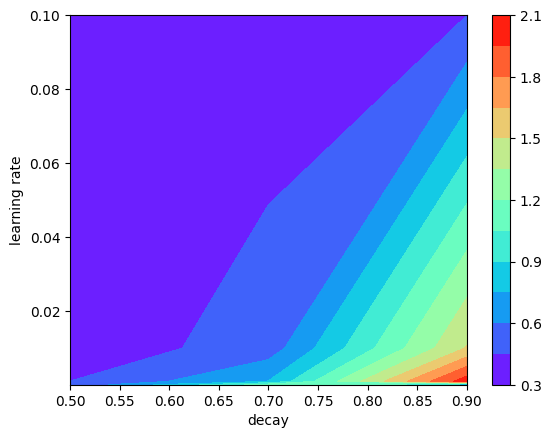

In [ ]:
# regrets = np.array(regrets)
# regret_plot = np.reshape(regrets[:,2], (len( lr_list),len(decay_list)))
# print(regret_plot)
# CS = plt.contourf(decay_list,lr_list,  regret_plot, 15, cmap=plt.cm.rainbow)
# plt.colorbar()
# plt.xlabel('decay')
# plt.ylabel('learning rate')
# plt.show()

In [ ]:
#learning from teacher's label
# Transform labels to represent logistic regression
# y_logistic = np.random.binomial(1, 1 / (1 + np.exp(-(np.dot(X[:, teacher_feature_set], learned_true_feature_teacher[teacher_feature_set]) + learned_hidden_feature_value_teacher))), size=N)
y_logistic = 1 / (1 + np.exp(-(np.dot(X[:, teacher_feature_set], learned_true_feature_teacher[teacher_feature_set]) + learned_hidden_feature_value_teacher)))

learned_true_feature_student_from_teacher, learned_hidden_feature_value_student_from_teacher, logit_losses_student, regrets_from_teacher = adagrad_optimizer_teacher_logit_with_regret(
    X, y_logistic, student_feature_set, has_baseline=True, features_baseline = learned_features_baseline, const_baseline = learned_const_feature_baseline)


sample 1/1000000, Regret: 0.026319774005359453, Learned Feature: [-0.40815575  1.44496351  0.09079602 -0.69758945  1.89115383], Constant Term: 0.6236516973890299
sample 10001/1000000, Regret: 8.177652599840918, Learned Feature: [0.75959236 0.19946339 0.51876551 0.39310481 0.63591358], Constant Term: -0.3265356802324673
sample 20001/1000000, Regret: 9.202789764462938, Learned Feature: [0.75474266 0.22261334 0.51193418 0.43561121 0.64370716], Constant Term: -0.2818475996300577
sample 30001/1000000, Regret: 9.644824715811714, Learned Feature: [0.77012278 0.22717736 0.52346958 0.39040982 0.6748661 ], Constant Term: -0.3238854673777434
sample 40001/1000000, Regret: 9.939268078466661, Learned Feature: [0.74143871 0.26665299 0.51423926 0.37889518 0.66849116], Constant Term: -0.2888160094895847
sample 50001/1000000, Regret: 10.32319353023697, Learned Feature: [0.73242127 0.22008955 0.51590886 0.37253981 0.65155681], Constant Term: -0.29619432902530224
sample 60001/1000000, Regret: 10.620636202

In [ ]:

learned_true_feature_student, learned_hidden_feature_value_student, logit_losses_student, regrets_from_data = adagrad_optimizer_teacher_logit_with_regret(
    X, y, student_feature_set, has_baseline=True, features_baseline = learned_features_baseline, const_baseline = learned_const_feature_baseline)


In [ ]:
# learn from binary teacher
y_logistic = np.random.binomial(1, 1 / (1 + np.exp(-(np.dot(X[:, teacher_feature_set], learned_true_feature_teacher[teacher_feature_set]) + learned_hidden_feature_value_teacher))), size=N)

learned_true_feature_student_from_binary_teacher, learned_hidden_feature_value_student_from_binary_teacher, logit_losses_student, regrets_from_binary_teacher = adagrad_optimizer_teacher_logit_with_regret(
    X, y_logistic, student_feature_set, has_baseline=True, features_baseline = learned_features_baseline, const_baseline = learned_const_feature_baseline)


sample 1/1000000, Average Regret: 1.1959692006061582, Learned Feature: [ 0.62451728 -0.46570116 -0.10215933  0.11641495  0.83716263], Constant Term: 1.304233956489141
sample 10001/1000000, Average Regret: 0.005434285033764829, Learned Feature: [0.61798948 0.06008855 0.4806645  0.44125104 0.53022814], Constant Term: -0.14295535524621814
sample 20001/1000000, Average Regret: 0.0032371760958816538, Learned Feature: [0.72452448 0.12006527 0.53572852 0.46609735 0.65187559], Constant Term: -0.27178983970168685
sample 30001/1000000, Average Regret: 0.002154916958863907, Learned Feature: [0.77008999 0.12631189 0.456806   0.45208404 0.71552497], Constant Term: -0.3119620815824283
sample 40001/1000000, Average Regret: 0.001787761327365336, Learned Feature: [0.78151511 0.25400159 0.51325056 0.3724641  0.68821717], Constant Term: -0.33963721494913535
sample 50001/1000000, Average Regret: 0.001549078930506047, Learned Feature: [0.75493779 0.26741928 0.49883282 0.32767238 0.6256273 ], Constant Term:

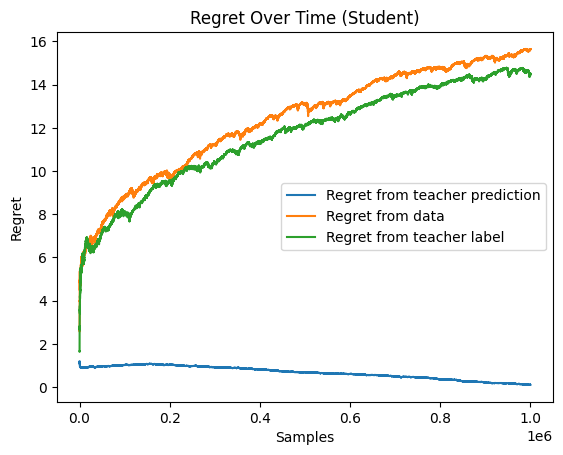

In [ ]:

# Plotting the logit loss and regret when the student learn from teacher prediction
horizon = np.array(range(1, len(regrets_from_teacher) + 1))
lb = 100
ub = 10**5 *10

plt.plot(horizon[lb:ub], regrets_from_teacher[lb:ub]*horizon[lb:ub]/np.log(horizon[lb:ub]), label='Regret from teacher prediction')
plt.xlabel('Samples')
plt.ylabel('Regret')
plt.title('Regret Over Time (Student)')
plt.legend()

# Plotting the logit loss and regret over epochs when student learn from raw data
horizon = np.array(range(1, len(regrets_from_data) + 1))

plt.plot(horizon[lb:ub], regrets_from_data[lb:ub]*horizon[lb:ub]/np.log(horizon[lb:ub]), label='Regret from data')
plt.legend()

# Plotting the logit loss and regret over epochs when student learn from binary labels generated by the teacher
horizon = np.array(range(1, len(regrets_from_binary_teacher) + 1))

plt.plot(horizon[lb:ub], regrets_from_binary_teacher[lb:ub]*horizon[lb:ub]/np.log(horizon[lb:ub]), label='Regret from teacher label')
plt.legend()

In [ ]:
print(regrets_from_teacher[-1])
print(regrets_from_data[-1])
print(regrets_from_binary_teacher[-1])

4.1203467061061205e-05
0.00021607615375908201
0.00020026360110437724
